In [1]:

import cooler
import cooltools
from cooltools.api.saddle import _make_cis_obsexp_fetcher
from cooltools.lib import numutils
from coolpuppy import coolpup
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup

import bioframe
import numpy as np
import pandas as pd
import bbi

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import multiprocessing

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


In [2]:
NPROC = 4
samples = ["t0", "t12"]
clrs_ = [
    cooler.Cooler(
        f"/home/carlos/oldies/manuscripts/notebooks/matrices/{sample}_q30.mcool::resolutions/10000"
    )
    for sample in samples
]

In [3]:
res_path = "/home/carlos/oldies/manuscripts/notebooks/gnn/results.tsv"
res = pd.read_csv(res_path, sep="\t")
res = res.rename(columns={"chr": "chrom"})
res = res.dropna(subset=['t0_q30-t12_q30', 't12_q30-t0_q30'], inplace=False)

In [4]:
comps = list(itertools.product([0,1], [0,1]))


In [5]:
flank = 500_000
import itertools

comps = list(itertools.product([0,1], [0,1]))

filter_for_highest_quartile = False
merge_regions = True

regions_df_ = []
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)].copy()

    if filter_for_highest_quartile:
        if i1 == 0:
            df = df.loc[df['t0_q30-t12_q30'] > df['t0_q30-t12_q30'].quantile(0.75)]
        if i2 == 0:
            df = df.loc[df['t12_q30-t0_q30'] > df['t12_q30-t0_q30'].quantile(0.75)]

    if merge_regions:
        merged_regions = bioframe.ops.merge(df, 0)
        merged_regions['start'] = merged_regions.apply(lambda x: x['start'] + (x['end'] - x['start']) // 2 - 5000, axis=1)
        merged_regions['end'] = merged_regions['start'] + 10000
        merged_regions['comp'] = f"{i1}-{i2}"
        regions_df_.append(merged_regions)

regions_df = pd.concat(regions_df_)

In [6]:
import data_handlers

In [7]:
import bbi
dnase_df = regions_df.copy()
dnase_df['val'] = bbi.stackup("/home/carlos/oldies/manuscripts/notebooks/bws/dnase.rpkm.bw", regions_df['chrom'], regions_df['start'], regions_df['end'], 1) / data_handlers.MEANS_BW['dnase']
dnase_df['data_name'] = "dnase"

faire_df = regions_df.copy()
faire_df['val'] = bbi.stackup("/home/carlos/Downloads/ENCFF000TKE_hg38.bigWig", regions_df['chrom'], regions_df['start'], regions_df['end'], 1).flatten() / data_handlers.MEANS_BW['faire']
faire_df['data_name'] = "faire"

data_df = pd.concat([dnase_df, faire_df])

0-0 (18666,)
0-1 (20530,)
1-0 (15356,)
1-1 (25782,)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-0 vs. 1-0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.425e-08 U_stat=1.355e+08
1-0 vs. 0-1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.154e-93 U_stat=1.624e+08
0-1 vs. 1-1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.172e-07 U_stat=2.464e+08
0-0 (18666,)
0-1 (20530,)
1-0 (15356,)
1-1 (25782,)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-0 vs. 1-0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.920e-04 U_stat=1.467e+08
1-0 vs. 0-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.232e-24 U_stat=1.676e+08
0-1 vs. 1-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.147e-05 U_stat=2.709e+08


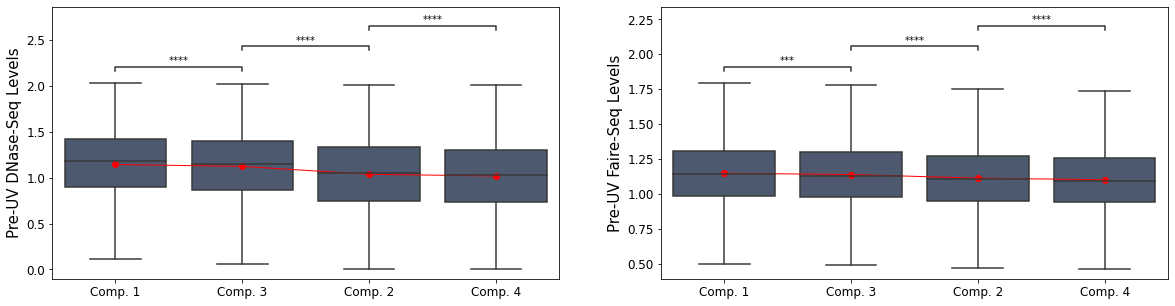

In [12]:
data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels'
}
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']
import itertools

comp_dict = {'0-0': 'Comp. 1', '0-1': 'Comp. 2', '1-0': 'Comp. 3', '1-1': 'Comp. 4'}

import numpy as np

for i, data_name in enumerate(data_name_mapping_anchors):
    ax = axs[i]
    df_now = data_df.loc[data_df['data_name'] == data_name].copy()

    medians_dict = {k: 0 for k in comp_dict.keys()}
    # Calculate the means for each category
    for k in comp_dict.keys():
        print(k, df_now.loc[df_now['comp'] == k, 'val'].shape)
        median_now = df_now.loc[df_now['comp'] == k, 'val'].median()
        medians_dict[k] = median_now
    medians_dict_sorted = dict(sorted(medians_dict.items(), key=lambda item: item[1], reverse=True))
    
    for k in medians_dict_sorted.keys():
        df_now.loc[df_now['comp'] == k, 'median'] = medians_dict[k]

    df_now.sort_values(by='median', ascending=False, inplace=True)
    
    # Plot the boxplots
    sns.boxplot(data=df_now, x='comp', y='val', ax=ax, showfliers=False, palette=["#465775"], notch=False)

    # Plot the means as red lines connecting them
    comp_order = df_now['comp'].unique()
    x_positions = np.arange(len(comp_order))  # Get x-positions of the boxplots
    means = [df_now.loc[df_now['comp'] == comp, 'val'].mean() for comp in comp_order]
    ax.plot(x_positions, means, color='red', marker='o', linestyle='-', lw=1, label='Mean')

    # Add statistical annotations
    #pairs = list(itertools.combinations(df_now['comp'].unique(), 2))
    pairs = [('0-0', '1-0'), ('1-0', '0-1'), ('0-1', '1-1')]
    from statannotations.Annotator import Annotator
    annotator = Annotator(ax, pairs, data=df_now, x='comp', y='val')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    # Customize plot appearance
    #ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=18)
    ax.set_ylabel(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
    ax.set_xlabel('')

    # set xtick labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([comp_dict[comp] for comp in comp_order], fontsize=18)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/gnn_dnase_faire.png", dpi=300, bbox_inches='tight')
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/gnn_dnase_faire.svg", bbox_inches='tight')